# Example : Beam Switching mode



In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
from lmtslr.spec import *
from lmtslr.spec import *
from lmtslr.ifproc import *
from lmtslr.viewer.spec_viewer import *
# from beam import *
# from beam_viewer import *

from lmtslr.utils.roach_file_utils import create_roach_list, lookup_roach_files
from lmtslr.utils.ifproc_file_utils import lookup_ifproc_file

from lmtslr.ifproc.ifproc import IFProcData, IFProcCal
from lmtslr.spec.spec import SpecBankCal, SpecBankData

testing TKAgg
use() got an unexpected keyword argument 'warn'
testing Agg
use() got an unexpected keyword argument 'warn'
testing GTKAgg
use() got an unexpected keyword argument 'warn'
testing Qt4Agg
use() got an unexpected keyword argument 'warn'
testing WXAgg
use() got an unexpected keyword argument 'warn'


In [2]:
path = os.environ['DATA_LMT']

# set all parameters to control the reduction and plot                                                                   
obsnum = 78085
pixel_number = 10
tsys = 150.

# designate pixels for the BS reduction                                                                                  
list_of_pixels = [8,10]

roach_list = create_roach_list(list_of_pixels)
use_calibration = True
baseline_order = 0
baseline_list = [[-200,-20],[20,200]]
line_integral_list = [[-20,20]]
plot_limits = [-200,200,-1,10]


In [3]:
# look up files to match pixel list                                                                                      
files,nfiles = lookup_roach_files(obsnum,roach_list,path=path+'/spectrometer')
ifproc_file = lookup_ifproc_file(obsnum,path+'/ifproc')
print(files,ifproc_file)
# create the spec_bank object.  This reads all the roaches in the list "files"                                           

I = IFProcData(ifproc_file)
S = SpecBankData(files,I,pixel_list=list_of_pixels,bank=0)

['/media/teuben/P1-2/teuben/LMT/lmt_data/spectrometer/roach2/roach2_78085_0_1_CHI-Cyg_2018-06-29_041715.nc'] /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078085_00_0001.nc
2018-06-29T00:17:18 begin /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078085_00_0001.nc
2018-06-29T00:18:34 end   /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078085_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
/media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078085_00_0001.nc does not have map parameters
78085 is a Bs observation
get chop
'Data.Msip1mm.BeamChopperActPos'
 no chop
read_roach /media/teuben/P1-2/teuben/LMT/lmt_data/spectrometer/roach2/roach2_78085_0_1_CHI-Cyg_2018-06-29_041715.nc     nspec,nchan=2384,2048
r:2 inp:0 pix:8 time_offset:-0.030000
r:2 inp:2 pix:10 time_offset:-0.030000


Traceback (most recent call last):
  File "/media/teuben/P1-2/teuben/LMT/SpectralLineReduction/lmtslr/ifproc/ifproc.py", line 570, in __init__
    self.chop = self.nc.variables['Data.Msip1mm.BeamChopperActPos'][:]
KeyError: 'Data.Msip1mm.BeamChopperActPos'


In [4]:
# check whether to use calibration and open necessary file                                                               
if use_calibration == True:
    S.cal_flag = False
    calobsnum = S.calobsnum
    cal_files,ncalfiles = lookup_roach_files(calobsnum,roach_list,path=path+'/spectrometer')
    ifproc_cal_file = lookup_ifproc_file(calobsnum,path=path+'/ifproc')
    print(cal_files,ifproc_cal_file)
    ICal = IFProcCal(ifproc_cal_file)
    SCal = SpecBankCal(cal_files,ICal,pixel_list=list_of_pixels)
    check_cal = SCal.test_cal(S)
    if check_cal > 0:
        print('WARNING: CAL MAY NOT BE CORRECT')

    # reduce the two spectra - calibrated                                                                                
    S.roach[0].reduce_ps_spectrum(stype=2,calibrate=True,tsys_spectrum=SCal.roach[0].tsys_spectrum)
    S.roach[1].reduce_ps_spectrum(stype=2,normal_ps=False,calibrate=True,tsys_spectrum=SCal.roach[1].tsys_spectrum)

else:
    # reduce the two spectra - uncalibrated                                                                              
    S.roach[0].reduce_ps_spectrum(stype=2,calibrate=False)
    S.roach[1].reduce_ps_spectrum(stype=2,normal_ps=False,calibrate=False)


['/media/teuben/P1-2/teuben/LMT/lmt_data/spectrometer/roach2/roach2_78082_0_1_CHI-Cyg_2018-06-29_041351.nc'] /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078082_00_0001.nc
2018-06-29T00:13:54 begin /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078082_00_0001.nc
2018-06-29T00:14:05 end   /media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078082_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
/media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078082_00_0001.nc does not have map parameters
/media/teuben/P1-2/teuben/LMT/lmt_data/ifproc/ifproc_2018-06-29_078082_00_0001.nc does not have bs parameters
78082 is a Cal observation
get chop cal
'Data.Msip1mm.BeamChopperActPos'
 no chop cal
read_roach /media/teuben/P1-2/teuben/LMT/lmt_data/spectrometer/roach2/roach2_78082_0_1_CHI-Cyg_2018-06-29_041351.nc     nspec,nchan=392,2048
r:2 inp:0 pix:8 time_offset:-0.030000
r:2 inp:2 pix:10 time

Traceback (most recent call last):
  File "/media/teuben/P1-2/teuben/LMT/SpectralLineReduction/lmtslr/ifproc/ifproc.py", line 701, in __init__
    self.chop = self.nc.variables['Data.Msip1mm.BeamChopperActPos'][:]
KeyError: 'Data.Msip1mm.BeamChopperActPos'
/media/teuben/P1-2/teuben/LMT/SpectralLineReduction/lmtslr/spec/spec.py:547: RuntimeWarning: divide by zero encountered in true_divide
  self.tsys_spectrum = 280 * sky_spectrum / (hot_spectrum -


In [5]:
# set the baseline channels from velocities                                                                              
blist,nb = S.make_velocity_list(baseline_list,id='baseline')
# set the line integration channels from velocities                                                                      
clist,nc = S.make_velocity_list(line_integral_list,id='line')



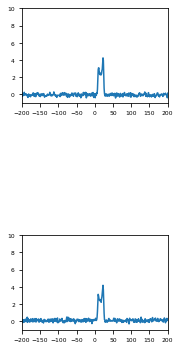

In [6]:
v = S.create_velocity_scale()

pl.figure(1,figsize=(12,8))
plot_order = [1,5,9,13,2,6,10,14,3,7,11,15,4,8,12,16];
for ipix in range(S.npix):
    pixel_id = S.roach_pixel_ids[ipix]
    ax = pl.subplot(4,4,plot_order[pixel_id])
    ax.tick_params(axis='both',which='major',labelsize=6)
    ax.tick_params(axis='both',which='minor',labelsize=6)
    if use_calibration:
        pl.plot(v,S.roach[ipix].ps_spectrum)
        pl.axis(plot_limits)
    else:
        pl.plot(v,S.roach[ipix].ps_spectrum*tsys)
        pl.axis(plot_limits)


In [7]:
if use_calibration:
    # calibration has been applied                                                                                       
    theSpectrum = (S.roach[0].ps_spectrum+S.roach[1].ps_spectrum)/2.
else:
    # calibration not applied, so multiply by tsys                                                                       
    theSpectrum = (S.roach[0].ps_spectrum+S.roach[1].ps_spectrum)/2. * tsys
if False:
    # orign
    line_stat = S.roach[0].line_statistics(S.roach[0],
                                       v,
                                       theSpectrum,
                                       clist,nc,
                                       blist,nb,baseline_order)
    print('BS PIX0=%2d PIX1=%2d YMAX=%.3f CMAX=%d XMAX=%.3f YINT=%.3f YERR=%.3f XMEAN=%.3f XWIDTH=%.3f RMS=%.3f'%(S.roach_pixel_ids[0],S.roach_pixel_ids[1],line_stat.ymax,line_stat.cmax,line_stat.xmax,line_stat.yint,line_stat.yerr,line_stat.xmean,line_stat.xwidth,line_stat.rms))
    pl.plot(line_stat.v,line_stat.spectrum)
    pl.axis([-100,100,-1,10])


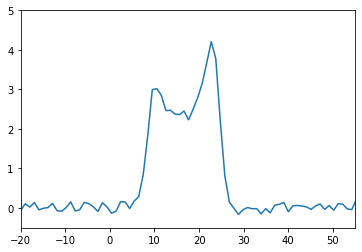

In [8]:
plot_limits=[-20,55,-0.5,5]
pl.axis(plot_limits)
pl.plot(v,theSpectrum)